# Visualisation and stats on the topic graphs

In [1]:
import sys
import os
import igraph
import matplotlib.pyplot as plt 
import nest_asyncio
nest_asyncio.apply()
import asyncio
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import linregress
import seaborn as sns
from datetime import datetime
import py4cytoscape as p4c # note that Cytoscape has to be installed and open on your machine for visualisation to work


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
from pubmetric import pckg_dev as dev
import pubmetric.network as nw

from style import palette as palette


In [2]:
proteomics_path = '../out/out_20240814142510' 
proteomics_graph = asyncio.run(nw.create_network(inpath=proteomics_path, load_graph=True))

metabolomics_path = '../out/out_20240814143203' 
metabolomics_graph = asyncio.run(nw.create_network(inpath=metabolomics_path, load_graph=True))

genomics_path = '../out/out_20240814151828' 
genomics_graph = asyncio.run(nw.create_network(inpath=genomics_path, load_graph=True))

graph_list = [proteomics_graph, metabolomics_graph, genomics_graph]
graph_name_list = ["Proteomics Domain", "Metabolomics Domain", "Genomics Domain"]
graph_stat_list = [(1874, 1527), (695, 585), (1778, 1540)] # (nr of tools in domain, tools in domain with pmid)

2024-08-25 17:29:50 - Loading graph from ../out/out_20240814142510/graph.pkl.
2024-08-25 17:29:50 - Graph loaded from ../out/out_20240814142510/graph.pkl.
2024-08-25 17:29:50 - Complete data download and graph creation took 0:00:00.008923
2024-08-25 17:29:50 - Loading graph from ../out/out_20240814143203/graph.pkl.
2024-08-25 17:29:50 - Graph loaded from ../out/out_20240814143203/graph.pkl.
2024-08-25 17:29:50 - Complete data download and graph creation took 0:00:00.001992
2024-08-25 17:29:50 - Loading graph from ../out/out_20240814151828/graph.pkl.
2024-08-25 17:29:50 - Graph loaded from ../out/out_20240814151828/graph.pkl.
2024-08-25 17:29:50 - Complete data download and graph creation took 0:00:00.011919


In [3]:
print(sum([e['weight'] for e in proteomics_graph.es]),( len(proteomics_graph.vs)**2)*np.mean(proteomics_graph.vs['nr_citations']), np.mean(proteomics_graph.vs['nr_citations']))

65861 146245120.0 116.58571428571429


Firstly some stats global graph stats on the three graphs.
* The vertex and edge attributes describe what metadata we have about papers and co-citations. 
* The number of vertices and edges reflect the size of the graph, and max edge weight shows the strongest co-citation relationships. 
* Average degree indicates how connected papers are on average. 
* The clustering coefficient indicate tool clusters. Groups of tools that are often cited together.
* The number of connected components and largest component size show graph fragmentation (explain further) and the size of the largest tool group. 
* Average path length reveals how closely tools are connected. 
* Betweenness centrality highlights tools acting as bridges between tool groups. 
* Eigenvector centrality indicates influential tools within well-cited groups. 
* Density captures overall connectivity, while assortativity shows if highly cited tools tend to co-cite other highly cited tools. 
* Modularity and number of communities reflect the division of the graph into distinct tool groups or clusters.

In [4]:


for i, graph in enumerate(graph_list):
    print(graph_name_list[i])
    print("Creation date:", graph['creation_date'],"Topic:", graph['topic'], "Time:", graph['graph_creation_time'],  )
    print("Toltal number of tools in the domain", graph_stat_list[i][0])
    print("Number of tools with a PMID", graph_stat_list[i][1])
    print("Number of vertices:", len(graph.vs))
    print("Number of edges:", len(graph.es))
    print("Vertex attributes:", graph.vs.attributes())
    print("Edge attributes:", graph.es.attributes())
    print("Graph attributes:", graph.attributes())
    print("Max edge weight:", max(graph.es['weight']))
    print("Avg degree:", sum(graph.degree()) / len(graph.vs))
    print("Clustering coefficient:", graph.transitivity_avglocal_undirected())
    print("Num connected components:", len(graph.components()))
    print("Largest component size:", max(len(c) for c in graph.components()))
    print("Avg path length:", graph.average_path_length())
    print("Betweenness centrality:", sum(graph.betweenness()) / len(graph.vs))
    print("Eigenvector centrality:", sum(graph.eigenvector_centrality()) / len(graph.vs))
    print("Density:", graph.density())
    print("Assortativity degree:", graph.assortativity_degree())
    print("Modularity:", graph.community_multilevel().modularity)
    print("Num communities:", len(graph.community_multilevel()))
    
    print("\n" + "-"*30 + "\n")


Proteomics Domain
Creation date: 2024-08-25 17:29:50.838524 Topic: topic_0121 Time: 0:00:00.008948
Toltal number of tools in the domain 1874
Number of tools with a PMID 1527
Number of vertices: 1120
Number of edges: 16837
Vertex attributes: ['name', 'pmid', 'age', 'nr_citations']
Edge attributes: ['weight', 'inverted_weight']
Graph attributes: ['creation_date', 'topic', 'tool_selection', 'graph_creation_time']
Max edge weight: 1921
Avg degree: 30.06607142857143
Clustering coefficient: 0.5949176614831293
Num connected components: 3
Largest component size: 1116
Avg path length: 2.6057697871328185
Betweenness centrality: 892.0223214285709
Eigenvector centrality: 0.10823012153046357
Density: 0.026868696540278313
Assortativity degree: -0.1726781432413329
Modularity: 0.3070772716380199
Num communities: 8

------------------------------

Metabolomics Domain
Creation date: 2024-08-25 17:29:50.840854 Topic: topic_0121 Time: 0:00:00.002013
Toltal number of tools in the domain 695
Number of tools

This is making me think that I could make the citation download much more efficient by trunkating them at 2_000 or so citations

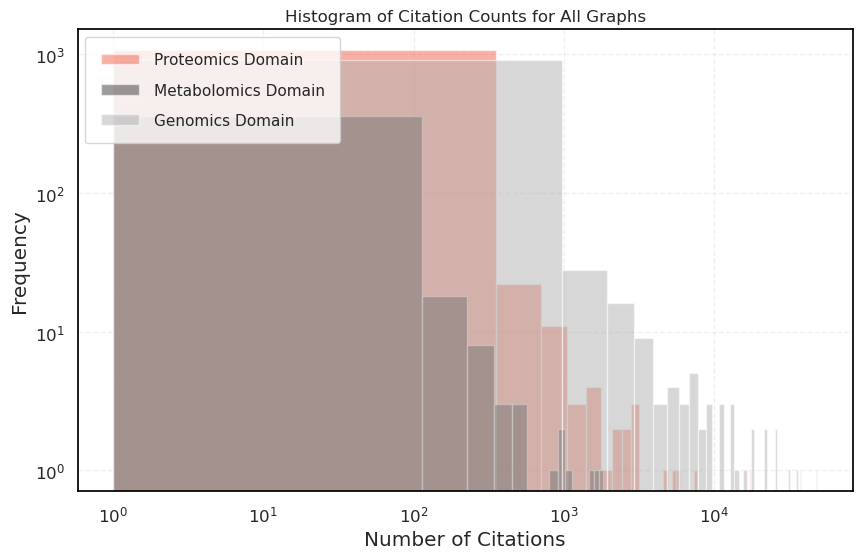

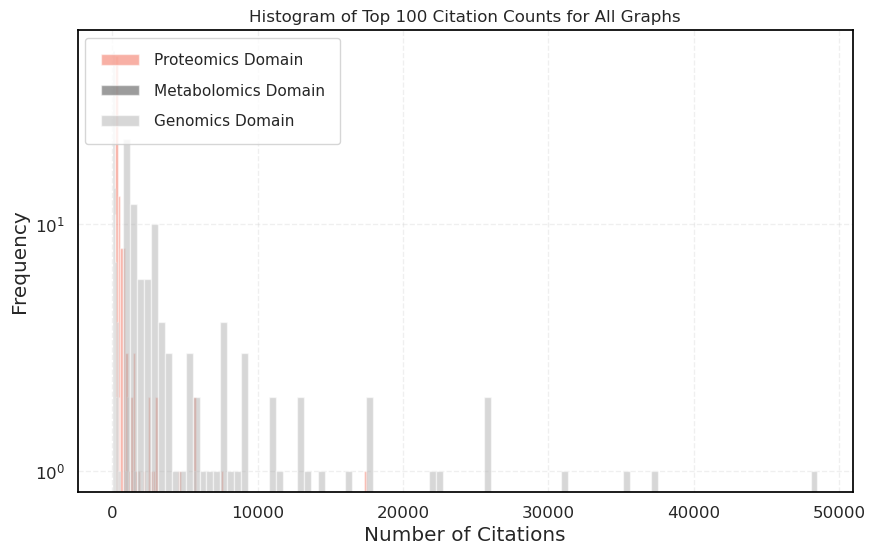

In [7]:

# Citation counts for each graph
plt.figure(figsize=(10, 6))
for i, graph in enumerate(graph_list):
    citation_counts = [tool['nr_citations'] for tool in graph.vs]
    plt.hist(citation_counts, bins=50, alpha=0.5, color=palette[i], label=graph_name_list[i])

plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of Citation Counts for All Graphs')
plt.legend()
plt.show()

# Plotting top 100 citation counts for each graph
plt.figure(figsize=(10, 6))
citations_list = []
for i, graph in enumerate(graph_list):
    citation_counts = [tool['nr_citations'] for tool in graph.vs]
    citations_list.append(citation_counts)
    sorted_citation_counts = sorted(citation_counts, reverse=True)
    top_citation_counts = sorted_citation_counts[:100]
    plt.hist(top_citation_counts, bins=100, alpha=0.5, color=palette[i], label=graph_name_list[i])

plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Top 100 Citation Counts for All Graphs')
plt.legend()
plt.show()


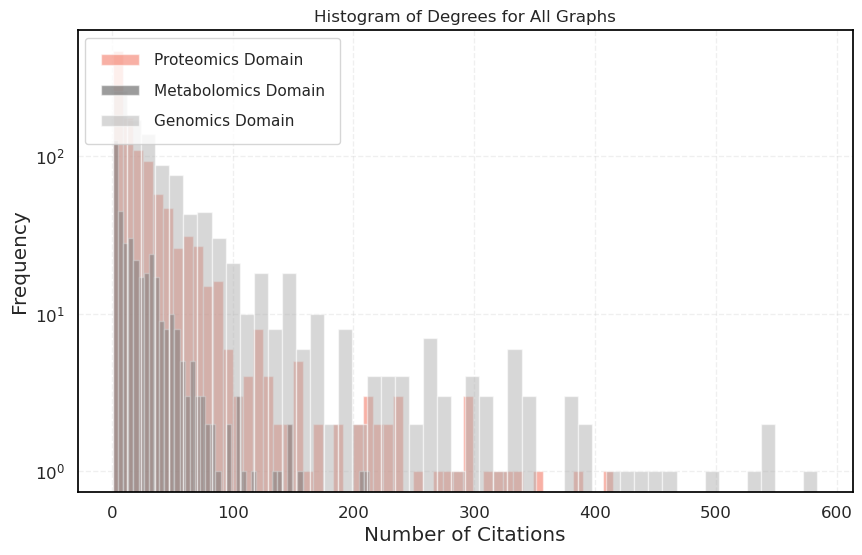

In [6]:
# Citation counts for each graph
plt.figure(figsize=(10, 6))
for i, graph in enumerate(graph_list):
    citation_counts = [tool.degree() for tool in graph.vs]
    plt.hist(citation_counts, bins=50, alpha=0.5, color=palette[i], label=graph_name_list[i])

plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Degrees for All Graphs')
plt.legend()
plt.show()

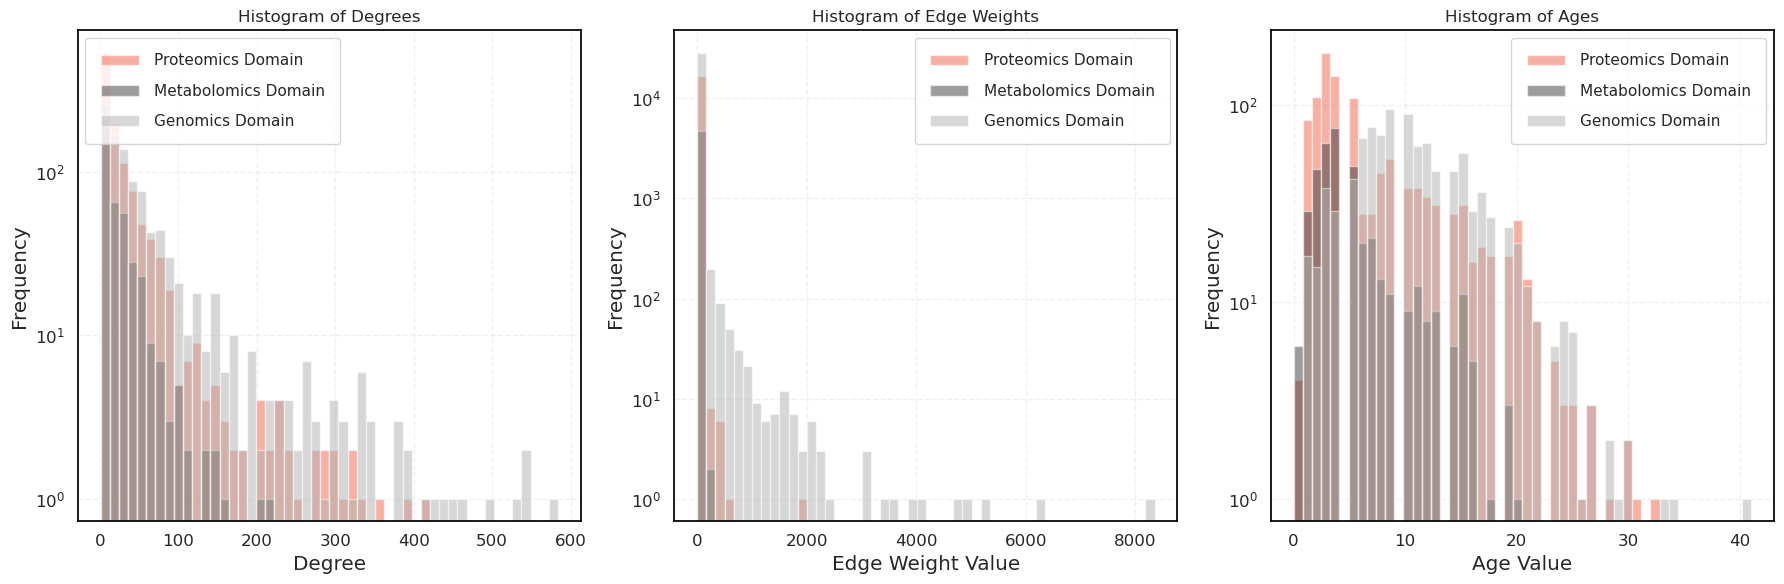

In [11]:
# Calculate the ranges for citation counts, edge weights, and ages across all graphs
all_citation_counts = []
all_edge_weights = []
all_ages = []

for graph in graph_list:
    all_citation_counts.extend([tool.degree() for tool in graph.vs])
    all_edge_weights.extend(graph.es['weight'])
    all_ages.extend(graph.vs['age'])

min_citation = min(all_citation_counts)
max_citation = max(all_citation_counts)

min_weight = min(all_edge_weights)
max_weight = max(all_edge_weights)

min_age = min(all_ages)
max_age = max(all_ages)

# common bin edges
citation_bin_edges = np.linspace(min_citation, max_citation, 51)  # 50 bins
weight_bin_edges = np.linspace(min_weight, max_weight, 51)  # 50 bins
age_bin_edges = np.linspace(min_age, max_age, 51)  # 50 bins

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, graph in enumerate(graph_list):
    citation_counts = [tool.degree() for tool in graph.vs]
    axes[0].hist(citation_counts, bins=citation_bin_edges, alpha=0.5, color=palette[i], label=graph_name_list[i])

axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].set_title('Histogram of Degrees')
axes[0].legend()

for i, graph in enumerate(graph_list):
    edge_weights = graph.es['weight']
    axes[1].hist(edge_weights, bins=weight_bin_edges, alpha=0.5, color=palette[i], label=graph_name_list[i])

axes[1].set_xlabel('Edge Weight Value')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_title('Histogram of Edge Weights')
axes[1].legend(loc='upper right')

for i, graph in enumerate(graph_list):
    ages = graph.vs['age']
    axes[2].hist(ages, bins=age_bin_edges, alpha=0.5, color=palette[i], label=graph_name_list[i])

axes[2].set_xlabel('Age Value')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')
axes[2].set_title('Histogram of Ages')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()


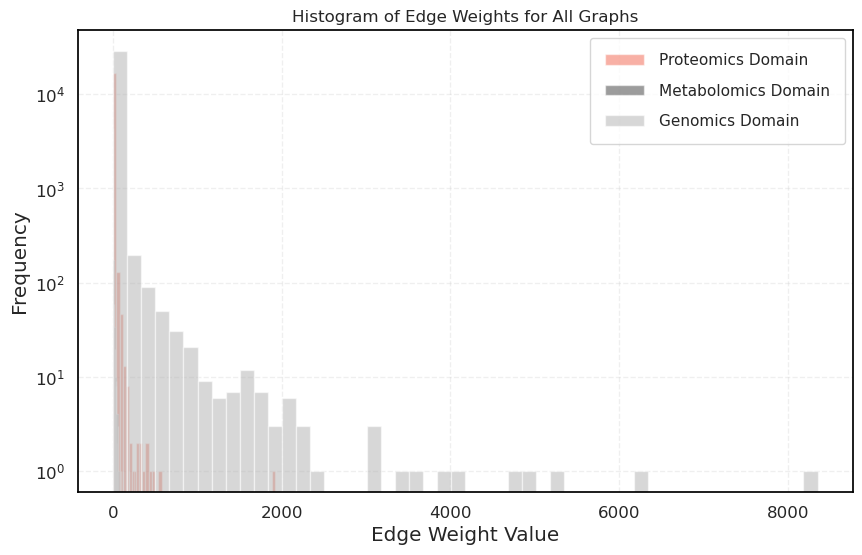

95th Percentile of Edge Weights for Proteomics Domain: 12.0
95th Percentile of Edge Weights for Metabolomics Domain: 8.0
95th Percentile of Edge Weights for Genomics Domain: 44.0


In [7]:
plt.figure(figsize=(10, 6))
edge_weight_list = []
for i, graph in enumerate(graph_list):
    edge_weights = graph.es['weight']
    edge_weight_list.append(edge_weights)
    plt.hist(edge_weights, bins=50, alpha=0.5, color=palette[i], label=graph_name_list[i])

plt.xlabel('Edge Weight Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights for All Graphs')
plt.legend(loc='upper right')
plt.show()

for i, graph in enumerate(graph_list):
    edge_weights = graph.es['weight']
    print(f"95th Percentile of Edge Weights for {graph_name_list[i]}: {np.percentile(edge_weights, 95)}")


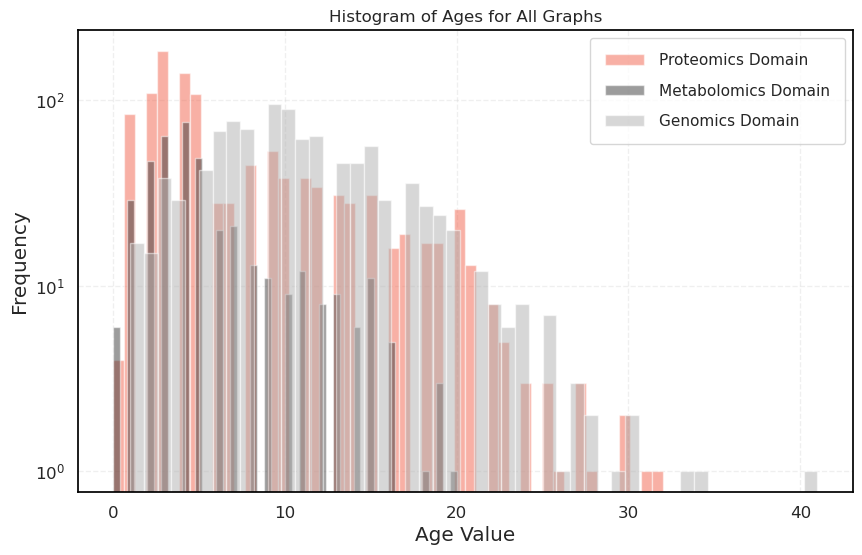

In [8]:
plt.figure(figsize=(10, 6))
age_list = []

for i, graph in enumerate(graph_list):
    ages = graph.vs['age']
    age_list.append(ages)
    plt.hist(ages, bins=50, alpha=0.5, color=palette[i], label=graph_name_list[i])

plt.xlabel('Age Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Ages for All Graphs')
plt.legend(loc='upper right')
plt.show()


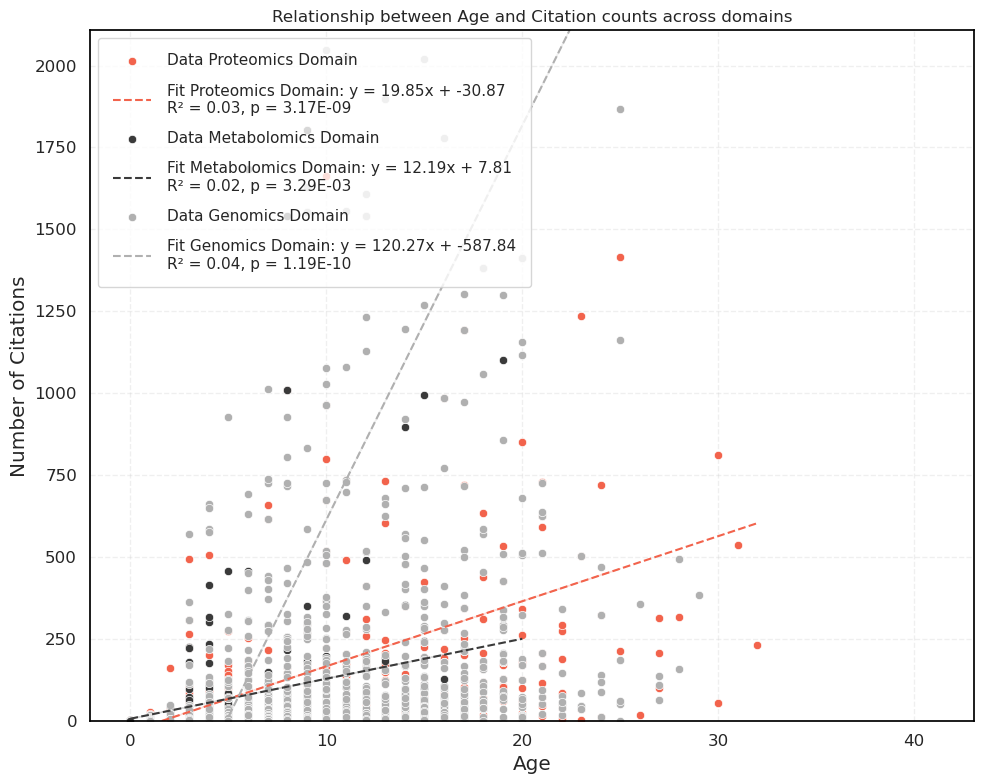

In [12]:
plt.figure(figsize=(10, 8))
for i, name in enumerate(graph_name_list):
    filtered_data = [(age, citation) for age, citation in zip(age_list[i], citations_list[i]) if age < 50]
    ages_filtered, citations_filtered = zip(*filtered_data)
    slope, intercept, r_value, p_value, std_err = linregress(ages_filtered, citations_filtered)
    line = slope * np.array(ages_filtered) + intercept
    sns.scatterplot(x=ages_filtered, y=citations_filtered, label=f'Data {name}', color=palette[i % len(palette)])
    sns.lineplot(x=ages_filtered, y=line, label=f'Fit {name}: y = {slope:.2f}x + {intercept:.2f}\n'
                                               f'R² = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[i % len(palette)], linestyle='--')

plt.title("Relationship between Age and Citation counts across domains")
plt.xlabel('Age')
plt.ylabel('Number of Citations')
plt.ylim(bottom=0, top=np.percentile(citations_list[0], 99)) 
plt.legend()
plt.tight_layout()
plt.show()


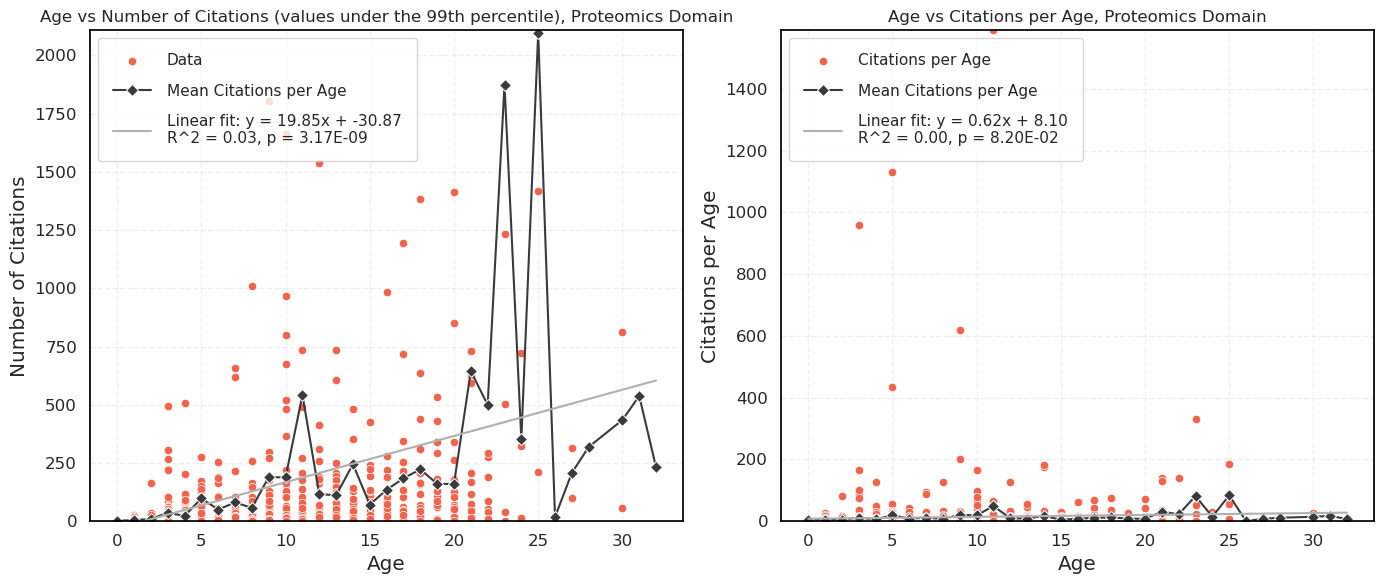

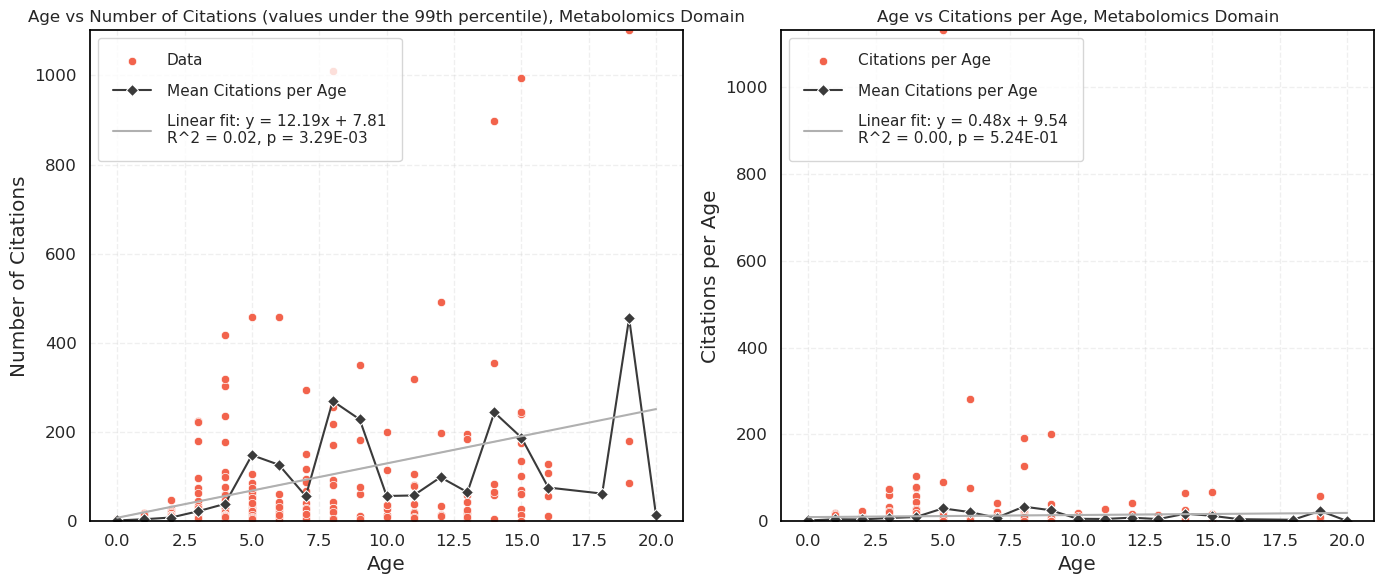

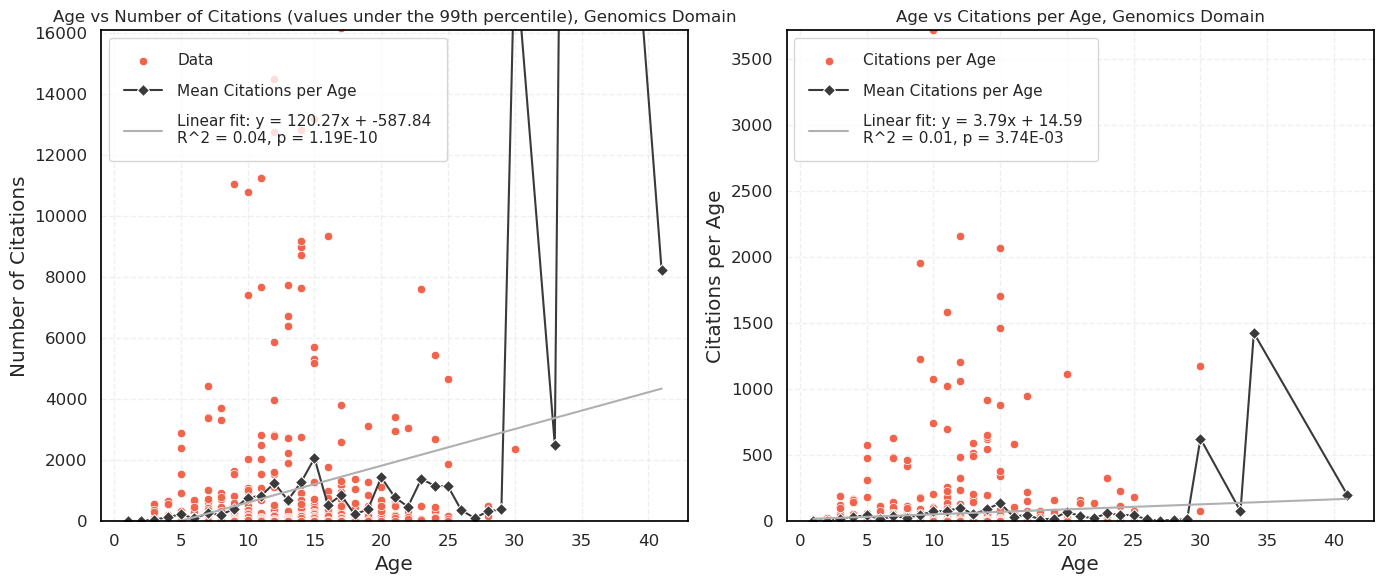

In [64]:
for i, name in enumerate(graph_name_list): 
    # rm ages 50 or above
    filtered_data = [(age, citation) for age, citation in zip(age_list[i], citations_list[i]) if age < 50]
    ages_filtered, citations_filtered = zip(*filtered_data)

    slope, intercept, r_value, p_value, std_err = linregress(ages_filtered, citations_filtered)
    line = slope * np.array(ages_filtered) + intercept

    data = pd.DataFrame({'age': ages_filtered, 'citation': citations_filtered})
    mean_citations = data.groupby('age')['citation'].mean().reset_index()

    # Calculate citations divided by age to compare the og with 
    citations_divided_by_age = [citation / age if age > 0 else citation for citation, age in zip(citations_filtered, ages_filtered)]

    slope_div, intercept_div, r_value_div, p_value_div, std_err_div = linregress(ages_filtered, citations_divided_by_age)
    line_div = slope_div * np.array(ages_filtered) + intercept_div

    data_div = pd.DataFrame({'age': ages_filtered, 'citation_div': citations_divided_by_age})
    mean_citations_div = data_div.groupby('age')['citation_div'].mean().reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.scatterplot(x=ages_filtered, y=citations_filtered, ax=axes[0], label='Data', color=palette[0])
    sns.lineplot(x=mean_citations['age'], y=mean_citations['citation'], ax=axes[0], marker='D', label='Mean Citations per Age', color=palette[1])
    sns.lineplot(x=ages_filtered, y=line, ax=axes[0], label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                                    f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[2])
    axes[0].set_title(f'Age vs Number of Citations (values under the 99th percentile), {name}')
    axes[0].set_xlabel('Age')
    axes[0].set_ylabel('Number of Citations')
    axes[0].set_ylim(bottom=0, top=np.percentile(citations_list[i], 99))  # Cutting off the top to see the line better
    axes[0].legend()

    sns.scatterplot(x=ages_filtered, y=citations_divided_by_age, ax=axes[1], label='Citations per Age', color=palette[0])
    sns.lineplot(x=mean_citations_div['age'], y=mean_citations_div['citation_div'], ax=axes[1], marker='D', label='Mean Citations per Age', color=palette[1])
    sns.lineplot(x=ages_filtered, y=line_div, ax=axes[1], label=f'Linear fit: y = {slope_div:.2f}x + {intercept_div:.2f}\n'
                                                    f'R^2 = {r_value_div**2:.2f}, p = {p_value_div:.2E}', color=palette[2])
    axes[1].set_title(f'Age vs Citations per Age, {name}')
    axes[1].set_xlabel('Age')
    axes[1].set_ylabel('Citations per Age')
    axes[1].set_ylim(bottom=0, top=np.nanmax(citations_divided_by_age)) 
    axes[1].legend()

    plt.tight_layout()
    plt.show()


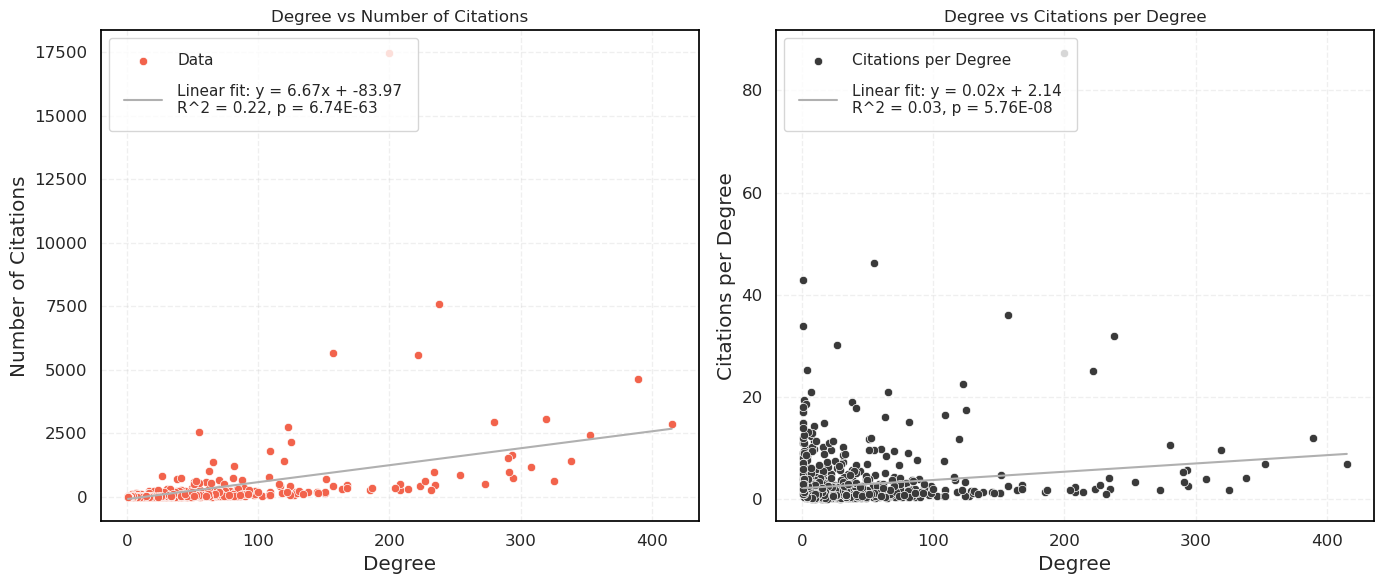

In [65]:
# now same thing for degrees, but just one ex
degrees = [vs.degree() for vs in proteomics_graph.vs]

slope, intercept, r_value, p_value, std_err = linregress(degrees, citations_list[0])
line = slope * np.array(degrees) + intercept

# Calculate citations divided by degrees to compare with 
citations_divided_by_degrees = [citation / degree if degree > 0 else citation for citation, degree in zip(citations_list[0], degrees)]

slope_div, intercept_div, r_value_div, p_value_div, std_err_div = linregress(degrees, citations_divided_by_degrees)
line_div = slope_div * np.array(degrees) + intercept_div

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=degrees, y=citations_list[0], ax=axes[0], label='Data', color=palette[0])
sns.lineplot(x=degrees, y=line, ax=axes[0], label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                                f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[2])
axes[0].set_title('Degree vs Number of Citations')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Number of Citations')
axes[0].legend()

sns.scatterplot(x=degrees, y=citations_divided_by_degrees, ax=axes[1], label='Citations per Degree', color=palette[1])
sns.lineplot(x=degrees, y=line_div, ax=axes[1], label=f'Linear fit: y = {slope_div:.2f}x + {intercept_div:.2f}\n'
                                                f'R^2 = {r_value_div**2:.2f}, p = {p_value_div:.2E}', color=palette[2])
axes[1].set_title('Degree vs Citations per Degree')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Citations per Degree')
axes[1].legend()

plt.tight_layout()
plt.show()


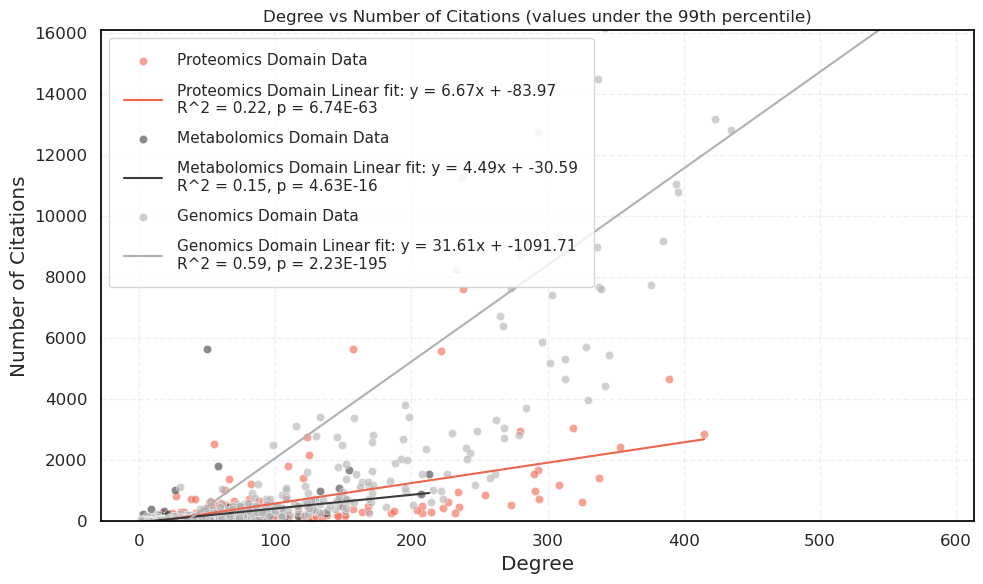

In [66]:

plt.figure(figsize=(10, 6))

for i, graph in enumerate(graph_list):
    degrees = [vs.degree() for vs in graph.vs]
    citations = [vs['nr_citations'] for vs in graph.vs]
    slope, intercept, r_value, p_value, std_err = linregress(degrees, citations)
    line = slope * np.array(degrees) + intercept
    sns.scatterplot(x=degrees, y=citations, label=f'{graph_name_list[i]} Data', color=palette[i], alpha=0.6)
    sns.lineplot(x=degrees, y=line, label=f'{graph_name_list[i]} Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                          f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[i])

plt.title('Degree vs Number of Citations (values under the 99th percentile)')
plt.xlabel('Degree')
plt.ylabel('Number of Citations')

plt.ylim(bottom=0, top=np.percentile(citations, 99))

plt.legend()
plt.tight_layout()
plt.show()


# Visualisation

In [67]:
def add_degree(graph: igraph.Graph):

    for vertex in graph.vs:
        vertex['degree'] = vertex.degree()


    return graph

In [68]:
small_graph_list = []
for i, graph in enumerate(graph_list):   
    vertices_to_remove = [v.index for v in graph.vs if v.degree() < 20]
    graph_small = graph.copy()
    graph_small.delete_vertices(vertices_to_remove)
    small_graph_list.append(add_degree(graph_small))

    original_vertices = len(graph.vs)
    original_edges = len(graph.es)
    new_vertices = len(graph_small.vs)
    new_edges = len(graph_small.es)

    vertex_decrease_percentage = ((original_vertices - new_vertices) / original_vertices) * 100
    edge_decrease_percentage = ((original_edges - new_edges) / original_edges) * 100

    print(f"Original {graph_name_list[i].split(' ')[0]} graph had {original_vertices} vertices and {original_edges} edges, "
        f"the smaller graph has {new_vertices} vertices and {new_edges} edges.")
    print(f"Percentage decrease in vertices: {vertex_decrease_percentage:.2f}%")
    print(f"Percentage decrease in edges: {edge_decrease_percentage:.2f}%")

Original Proteomics graph had 1120 vertices and 16837 edges, the smaller graph has 451 vertices and 12504 edges.
Percentage decrease in vertices: 59.73%
Percentage decrease in edges: 25.73%
Original Metabolomics graph had 401 vertices and 4695 edges, the smaller graph has 159 vertices and 3191 edges.
Percentage decrease in vertices: 60.35%
Percentage decrease in edges: 32.03%
Original Genomics graph had 1005 vertices and 28952 edges, the smaller graph has 637 vertices and 25742 edges.
Percentage decrease in vertices: 36.62%
Percentage decrease in edges: 11.09%


In [69]:
current_time = datetime.now().strftime("%Y%m%d%H%M")

for i, graph in enumerate(small_graph_list):
    p4c.create_network_from_igraph(graph, f"{graph_name_list[i].split(' ')[0]}_cocitation_graph_{current_time}", collection="Co-citation networks")

Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
Applying default style...
Applying preferred layout
